In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch


In [2]:
### FROM CLASS NOTEBOOKS

def inspect_batch(images: torch.Tensor, # batch of images as torch tensors
        labels: torch.Tensor=None,      # optional vector of ground truth label integers
        predictions: torch.Tensor=None, # optional vector/matrix of model predictions
        # display parameters:
        class_names: list[str]=None, # optional list or dict of class idxs to class name strings
        title: str=None,       # optional title for entire plot    
        # figure display/sizing params:
        center_title=True,
        max_to_show=25,
        num_cols = 5,
        scale=0.6,
        ):
    """accepts a batch of images as a torch tensor or list of tensors,
    and plots them in a grid for manual inspection.
    optionally, you can supply ground truth labels
    and/or model predictions, to display those as well."""

    if type(images) is tuple:
        raise Exception('Expected first input as torch.Tensor, but got tuple; make sure to pass images and labels separately!')
    
    max_to_show = min([max_to_show, len(images)]) # cap at number of images
    
    num_rows = int(np.ceil(max_to_show / num_cols))

    # add extra figure height if needed for captions:
    extra_height = (((labels is not None)*0.3 + (predictions is not None))*0.3)

    fig_width = 2 * scale * num_cols
    fig_height = (2+extra_height) * scale * num_rows + ((title is not None) * 0.3)
    
    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))
    all_axes = []
    for ax_row in axes:
        all_axes.extend(ax_row)
    
    combined_labels = None
    if labels is not None:
        if isinstance(labels, tuple) and len(labels) == 2:
            super_labels, class_labels = labels
            combined_labels = [f"{super_labels[i]} \n {class_labels[i]}" for i in range(len(super_labels))]
        else:
            combined_labels = labels  # single label list as before

    combined_predictions = None
    if predictions is not None: 
        if isinstance(predictions, tuple) and len(predictions) == 2:
            super_pred, class_pred = predictions
            combined_predictions = [f"{super_pred[i]} \n {class_pred[i]}" for i in range(len(super_pred))]
        else: 
            combined_predictions = predictions


    for b, ax in enumerate(all_axes):
        if b < max_to_show:
            # rearrange to H*W*C:
            img_p = images[b].permute([1,2,0]) 
            # un-normalise:
            img = (img_p - img_p.min()) / (img_p.max() - img_p.min())
            # to numpy:
            img = img.cpu().detach().numpy()
            
            ax.imshow(img)
            ax.axes.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

            if combined_labels is not None:
                ax.set_title(combined_labels[b], fontsize=10 * scale**0.5)
            if combined_predictions is not None:
                ax.set_title(combined_predictions[b], fontsize=10 * scale**0.5)
            if combined_labels is not None and combined_predictions is not None:
                if combined_labels[b] == combined_predictions[b]:
                    ### matching prediction, mark as correct:
                    mark, color = '✔', 'green'
                else:
                    mark, color = '✘', 'red'
                
                ax.set_title(f'label:{combined_labels[b]}    \npred:{combined_predictions[b]} {mark}', color=color, fontsize=8*scale**0.5)
        else:
            ax.axis('off')
    if title is not None:
        if center_title:
            x, align = 0.5, 'center'
        else:
            x, align = 0, 'left'
        fig.suptitle(title, fontsize=14*scale**0.5, x=x, horizontalalignment=align)
    fig.tight_layout()
    plt.show()

In [3]:
class SportsDataset(Dataset):
    def __init__(self, csv_file, labelled=True, transform=None):
        """
        Args:
            csv_file (str): Path to CSV file with annotations.
            transform (callable, optional): Transform to be applied on an image.
        """
        self.data = pd.read_csv(csv_file)
        self.labelled = labelled                # TO ALLOW FOR BOTH SUPERCLASS AND CLASS OR ONLY SUPERCLASS
        self.transform = transform
        
        # # Build mappings for labels/superclasses → integers
        # self.label_to_idx = {label: idx for idx, label in enumerate(self.data['class'].unique())}
        # self.super_to_idx = {sup: idx for idx, sup in enumerate(self.data['superclass'].unique())}
        # print(self.label_to_idx)
        # print(self.super_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        path = row['filepath']
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        if self.labelled:
            # label = self.label_to_idx[row['class']]
            # superclass = self.super_to_idx[row['superclass']]
            label = row['class']
            superclass = row['superclass']
            
            return image, superclass, label 
        else:
            superclass = row['superclass']
            return image, superclass

In [4]:
# merge the two csv with one having: filepath, superclass, class 

df1 = pd.read_csv("archive (1)/train.csv")
df2 = pd.read_csv("archive (2)/sports.csv")

df1["filepath"] = "archive (1)/train/" + df1["label"] + '/' + df1["filename"].astype(str)
df2["filepath"] = "archive (2)/" + df2["filepaths"].astype(str)

df1 = df1.rename(columns={
    "label": "class"
})

df2 = df2.rename(columns={
    "labels": "class"
})

# Keep only needed columns
df1_clean = df1[["filepath", "class"]]
df2_clean = df2[["filepath", "class"]]

merged_df = pd.concat([df1_clean, df2_clean], ignore_index=True)

merged_df.to_csv("merged_sports.csv", index=False)

merged_df.head()

#C:\Users\propietari\Downloads\AML\project\archive (1)\train\golf\Image_1.jpg

,filepath,class
0,archive (1)/train/golf/Image_1.jpg,golf
1,archive (1)/train/roller derby/Image_2.jpg,roller derby
2,archive (1)/train/high jump/Image_3.jpg,high jump
3,archive (1)/train/bungee jumping/Image_4.jpg,bungee jumping
4,archive (1)/train/rugby/Image_5.jpg,rugby


In [5]:
label_to_superclass = {
    "air hockey": "precision & target sports",
    "archery": "precision & target sports",
    'axe throwing': 'precision & target sports', 
    'billiards': 'precision & target sports',
    'bowling': 'precision & target sports',
    'croquet': 'precision & target sports',
    'curling': 'precision & target sports',
    'disc golf': 'precision & target sports',
    'golf': 'precision & target sports',
    'horseshoe pitching': 'precision & target sports',
    'shuffleboard': 'precision & target sports',

    'canoe slamon': 'water',
    'fly fishing': 'water',
    'hydroplane racing': 'water',
    'log rolling':'water',
    'rowing':'water',
    'sailboat racing':'water',
    'surfing':'water',
    'swimming':'water',
    'water cycling':'water',
    'water polo':'water',

    'ampute football': 'field & team ball sports',
    'baseball': 'field & team ball sports',
    'cricket': 'field & team ball sports',
    'field hockey': 'field & team ball sports',
    'football': 'field & team ball sports',
    'frisbee': 'field & team ball sports',
    'gaga': 'field & team ball sports',
    'lacrosse': 'field & team ball sports',
    'roller derby': 'field & team ball sports',
    'rugby': 'field & team ball sports',
    'ultimate': 'field & team ball sports',

    'basketball': 'court ball sports',
    'jai alai':'court ball sports',
    'tennis':'court ball sports',
    'volleyball':'court ball sports',
    'wheelchair basketball':'court ball sports',
    'table tennis':'court ball sports',

    'arm wrestling': 'combat & strength sports',
    'boxing':'combat & strength sports',
    'fencing':'combat & strength sports',
    'jousting':'combat & strength sports',
    'judo':'combat & strength sports',
    'olympic wrestling':'combat & strength sports',
    'rock climbing':'combat & strength sports',
    'steer wrestling':'combat & strength sports',
    'sumo wrestling':'combat & strength sports',
    'tug of war':'combat & strength sports',
    'weightlifting':'combat & strength sports',

    'barell racing': 'equestrian & animal sports',
    'bull riding':'equestrian & animal sports',
    'chuckwagon racing':'equestrian & animal sports',
    'harness racing':'equestrian & animal sports',
    'horse jumping':'equestrian & animal sports',
    'horse racing':'equestrian & animal sports',
    'polo':'equestrian & animal sports',

    'bobsled': 'ice & snow sports',
    'figure skating men':'ice & snow sports',
    'figure skating women':'ice & snow sports',
    'figure skating pairs':'ice & snow sports',
    'giant slalom':'ice & snow sports',
    'hockey':'ice & snow sports',
    'ice climbing':'ice & snow sports',
    'ice yachting':'ice & snow sports',
    'luge':'ice & snow sports',
    'mushing':'ice & snow sports',
    'ski jumping':'ice & snow sports',
    'snow boarding':'ice & snow sports',
    'snowmobile racing':'ice & snow sports',
    'speed skating':'ice & snow sports',

    'bike polo': 'motor & wheel racing',
    'bmx':'motor & wheel racing',
    'formula 1 racing':'motor & wheel racing',
    'motorcycle racing':'motor & wheel racing',
    'nascar racing':'motor & wheel racing',
    'rollerblade racing':'motor & wheel racing',
    'sidecar racing':'motor & wheel racing',
    'track bicycle':'motor & wheel racing',
    'wheelchair racing':'motor & wheel racing',

    'balance beam': 'gymnastics',
    'baton twirling':'gymnastics',
    'cheerleading':'gymnastics',
    'parallel bar':'gymnastics',
    'pole dancing':'gymnastics',
    'pommel horse':'gymnastics',
    'rings':'gymnastics',
    'trapeze':'gymnastics',
    'uneven bars':'gymnastics',

    'bungee jumping':'aerial',
    'hang gliding':'aerial',
    'sky surfing':'aerial',
    'skydiving':'aerial',
    'wingsuit flying':'aerial',

    'hammer throw': 'track & field athletics',
    'high jump':'track & field athletics',
    'hurdles':'track & field athletics',
    'javelin':'track & field athletics',
    'pole climbing':'track & field athletics',
    'pole vault':'track & field athletics',
    'shot put':'track & field athletics'
}

merged = 'merged_sports.csv'
superclass_merged = 'superclass_merged_sports.csv'

# in the merged csv: filepath, class
with open(merged, newline='', encoding='utf-8') as infile, \
     open(superclass_merged, 'w', newline='', encoding='utf-8') as outfile:

    reader = csv.DictReader(infile)
    
    original_fields = reader.fieldnames
    print(original_fields)
    reordered_fields = []
    for field in original_fields:
        if field == 'class':
            reordered_fields.append('superclass')
            reordered_fields.append('class')
        elif field != 'superclass':
            reordered_fields.append(field)

    writer = csv.DictWriter(outfile, fieldnames=reordered_fields)
    writer.writeheader()

    for row in reader:
        label = row['class']
        row['superclass'] = label_to_superclass.get(label, 'unknown')
        writer.writerow(row)

['filepath', 'class']


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor()          
])

dataset = SportsDataset(
    csv_file = 'superclass_merged_sports.csv',
    labelled = True,
    transform=transform
)

labelled_dataloader = DataLoader(dataset, batch_size=32, shuffle=True) #MODIFY BATCH SIZE

# for images, superclasses, classes in labelled_dataloader:
#     print(images.shape)   
#     print(superclasses)
#     print(classes)
#     break

In [11]:
images, superclasses, classes = next(iter(labelled_dataloader))
print(superclasses)
print(classes)


('field & team ball sports', 'court ball sports', 'precision & target sports', 'precision & target sports', 'water', 'precision & target sports', 'ice & snow sports', 'gymnastics', 'equestrian & animal sports', 'court ball sports', 'ice & snow sports', 'gymnastics', 'gymnastics', 'equestrian & animal sports', 'equestrian & animal sports', 'ice & snow sports', 'field & team ball sports', 'water', 'combat & strength sports', 'field & team ball sports', 'combat & strength sports', 'ice & snow sports', 'gymnastics', 'ice & snow sports', 'gymnastics', 'equestrian & animal sports', 'equestrian & animal sports', 'aerial', 'gymnastics', 'motor & wheel racing', 'equestrian & animal sports', 'ice & snow sports')
('frisbee', 'basketball', 'axe throwing', 'archery', 'canoe slamon', 'curling', 'giant slalom', 'rings', 'horse racing', 'tennis', 'snowmobile racing', 'baton twirling', 'parallel bar', 'polo', 'barell racing', 'ski jumping', 'roller derby', 'canoe slamon', 'steer wrestling', 'ultimate',

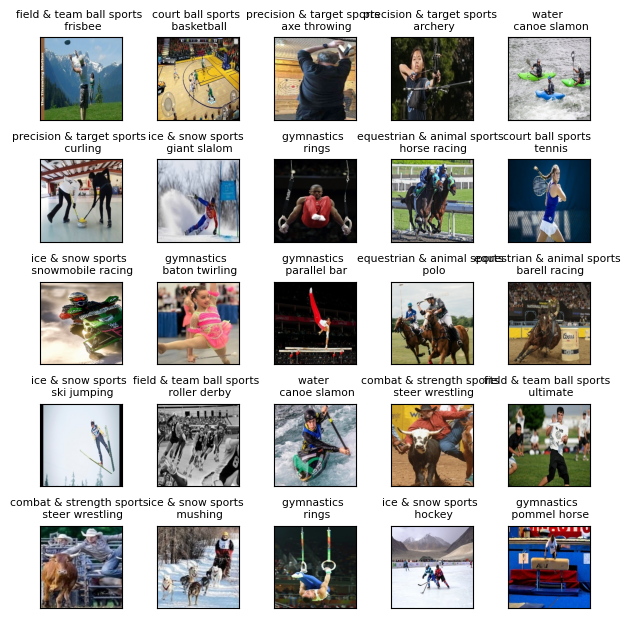

In [12]:
inspect_batch(images, labels=(superclasses, classes))
# inspect_batch(images, labels=(superclasses))

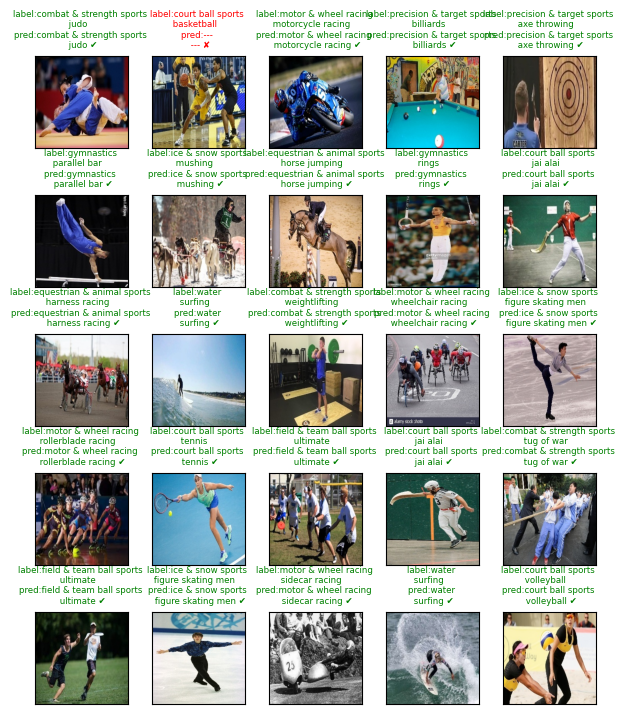

In [ ]:
pred_superclasses = ['combat & strength sports', '---', 'motor & wheel racing', 'precision & target sports', 'precision & target sports', 'gymnastics', 'ice & snow sports', 'equestrian & animal sports', 'gymnastics', 'court ball sports', 'equestrian & animal sports', 'water', 'combat & strength sports', 'motor & wheel racing', 'ice & snow sports', 'motor & wheel racing', 'court ball sports', 'field & team ball sports', 'court ball sports', 'combat & strength sports', 'field & team ball sports', 'ice & snow sports', 'motor & wheel racing', 'water', 'court ball sports', 'ice & snow sports', 'precision & target sports', 'water', 'combat & strength sports', 'ice & snow sports', 'water', 'ice & snow sports']
pred_classes = ['judo', '---', 'motorcycle racing', 'billiards', 'axe throwing', 'parallel bar', 'mushing', 'horse jumping', 'rings', 'jai alai', 'harness racing', 'surfing', 'weightlifting', 'wheelchair racing', 'figure skating men', 'rollerblade racing', 'tennis', 'ultimate', 'jai alai', 'tug of war', 'ultimate', 'figure skating men', 'sidecar racing', 'surfing', 'volleyball', 'hockey', 'horseshoe pitching', 'water cycling', 'fencing', 'mushing', 'swimming', 'figure skating pairs']

inspect_batch(images, labels=(superclasses, classes), predictions=(pred_superclasses, pred_classes))
# inspect_batch(images, labels=(superclasses), predictions=(pred_superclasses))
